# Análisis de Clusters: Perfiles Comportamentales de Estudiantes

Este notebook implementa **análisis de clustering** para identificar grupos naturales de estudiantes basados en sus patrones de comportamiento digital.

## Objetivos

1. **Identificar perfiles/tipologías** de estudiantes según indicadores digitales
2. **Comparar grupos** en términos de salud mental (DASS-21, UCLA)
3. **Complementar análisis de correlaciones** con enfoque multivariado
4. **Generar visualizaciones** interpretables para la tesis

## Métodos Utilizados

- **K-Means Clustering**: Algoritmo de partición
- **Clustering Jerárquico**: Para dendrograma
- **PCA (Análisis de Componentes Principales)**: Reducción dimensional para visualización
- **Silhouette Score**: Métrica de calidad del clustering
- **Radar Charts**: Comparación visual de perfiles


In [52]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples

# Visualización
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import mannwhitneyu, kruskal

import warnings
warnings.filterwarnings('ignore')

# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print("✓ Librerías importadas")

✓ Librerías importadas


## 1. Cargar y Preparar Datos

In [53]:
# Cargar dataset consolidado
df = pd.read_csv('../data/features/final/dataset_consolidado.csv')

print(f"Dataset cargado: {len(df)} participantes")
print(f"Variables disponibles: {len(df.columns)}")

# Crear carpeta de resultados
output_path = Path('../data/results')
output_path.mkdir(exist_ok=True, parents=True)

df.head()

Dataset cargado: 18 participantes
Variables disponibles: 43


,id_participante,num_publicaciones,promedio_palabras,promedio_caracteres,promedio_longitud_palabra,promedio_palabras_unicas,promedio_riqueza_lexica,promedio_exclamaciones,promedio_preguntas,promedio_pronombres_1era_sing,...,actividades_extra,miembro_wa,ucla_total,ucla_categoria,dass_depresion,dass_ansiedad,dass_estres,dass_depresion_cat,dass_ansiedad_cat,dass_estres_cat
0,EST001,1515,11.672607,62.170297,4.397393,10.619142,0.960832,0.006601,0.145875,1.619723,...,Sí,Sí,54,Alta soledad,28,10,28,Extremadamente severa,Moderada,Severo
1,EST002,589,9.509338,50.213922,4.310645,8.887946,0.976294,0.000000,0.110357,2.251290,...,No,Sí,44,Alta soledad,12,4,14,Leve,Normal,Normal
2,EST003,454,8.088106,48.504405,5.374670,7.568282,0.986749,0.033040,0.079295,1.486652,...,No,Sí,47,Alta soledad,20,20,30,Moderada,Extremadamente severa,Severo
3,EST004,1056,8.012311,40.735795,4.139915,7.578598,0.979777,0.009470,0.148674,1.886913,...,No,Sí,52,Alta soledad,18,30,30,Moderada,Extremadamente severa,Severo
4,EST007,723,10.507607,56.074689,4.329696,9.652835,0.960315,0.030429,0.069156,1.812573,...,Sí,Sí,57,Alta soledad,8,24,34,Normal,Extremadamente severa,Extremadamente severo


## 2. Seleccionar Variables para Clustering

In [54]:
# Indicadores digitales para clustering
features_clustering = [
    # Emocionales
    'promedio_score_positivo',
    'promedio_score_negativo',
    'promedio_alegria',
    'promedio_tristeza',
    'promedio_enojo',
    'promedio_miedo',
    
    # Lingüísticos
    'promedio_palabras',
    'promedio_riqueza_lexica',
    'promedio_pronombres_1era_sing',
    'promedio_absolutistas',
    'promedio_negativas',
    
    # Actividad
    'num_publicaciones',
    'total_emojis'
]

# Variables de salud mental (NO se usan para clustering, solo para comparación)
variables_salud = [
    'dass_depresion',
    'dass_ansiedad', 
    'dass_estres',
    'ucla_total'
]

print(f"\n📊 Features para clustering: {len(features_clustering)}")
print(f"📋 Variables de salud mental (comparación): {len(variables_salud)}")

# Extraer datos para clustering
X = df[features_clustering].copy()
print(f"\n✓ Matriz de features: {X.shape}")

# Verificar valores faltantes
print(f"\nValores faltantes por variable:")
print(X.isnull().sum()[X.isnull().sum() > 0])


📊 Features para clustering: 13
📋 Variables de salud mental (comparación): 4

✓ Matriz de features: (18, 13)

Valores faltantes por variable:
Series([], dtype: int64)


## 3. Normalización de Datos

**Importante**: K-Means es sensible a la escala de las variables. Normalizamos usando StandardScaler (media=0, std=1).

In [55]:
# Normalizar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertir a DataFrame para facilitar interpretación
X_scaled_df = pd.DataFrame(X_scaled, columns=features_clustering, index=df['id_participante'])

print("✓ Datos normalizados")
print(f"\nMedia de cada variable (debe ser ~0):")
print(X_scaled_df.mean())
print(f"\nDesviación estándar (debe ser ~1):")
print(X_scaled_df.std())

✓ Datos normalizados

Media de cada variable (debe ser ~0):
promedio_score_positivo         -2.282125e-16
promedio_score_negativo         -1.310680e-17
promedio_alegria                -4.317534e-17
promedio_tristeza                4.934325e-16
promedio_enojo                  -1.017704e-16
promedio_miedo                   1.372359e-16
promedio_palabras                3.978299e-16
promedio_riqueza_lexica          9.214851e-15
promedio_pronombres_1era_sing   -1.480297e-16
promedio_absolutistas            2.320675e-16
promedio_negativas               1.187322e-16
num_publicaciones               -1.541976e-17
total_emojis                     3.083953e-17
dtype: float64

Desviación estándar (debe ser ~1):
promedio_score_positivo          1.028992
promedio_score_negativo          1.028992
promedio_alegria                 1.028992
promedio_tristeza                1.028992
promedio_enojo                   1.028992
promedio_miedo                   1.028992
promedio_palabras                1.0289

## 4. Determinar Número Óptimo de Clusters

Usamos dos métodos:
1. **Método del Codo (Elbow)**: Busca "codo" en la curva de inercia
2. **Silhouette Score**: Mide qué tan bien está cada punto en su cluster

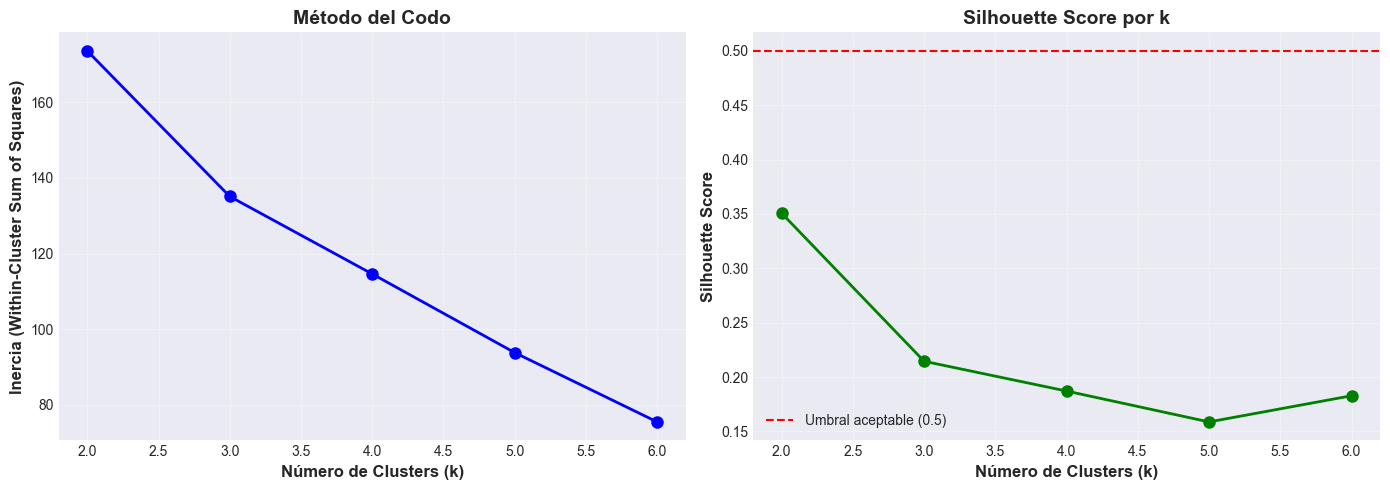


Análisis de k óptimo:
   Silhouette sugiere: k=2 (score=0.351)

   Tabla de Silhouette Scores:
   k=2: 0.351 ← ÓPTIMO (Silhouette)
   k=3: 0.215
   k=4: 0.187
   k=5: 0.159
   k=6: 0.183

✓ Gráfico guardado: ../data/results/clustering_elbow_silhouette.pdf


In [80]:
# Probar diferentes números de clusters
K_range = range(2, min(7, len(df)))  # De 2 a 6 clusters (o menos si n<7)
inertias = []
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Visualizar
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Método del Codo
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Número de Clusters (k)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Inercia (Within-Cluster Sum of Squares)', fontsize=12, fontweight='bold')
axes[0].set_title('Método del Codo', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Silhouette Score
axes[1].plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Número de Clusters (k)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[1].set_title('Silhouette Score por k', fontsize=14, fontweight='bold')
axes[1].axhline(y=0.5, color='r', linestyle='--', label='Umbral aceptable (0.5)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_path / 'clustering_elbow_silhouette.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Sugerir k óptimo basado en Silhouette
k_optimo_silhouette = K_range[np.argmax(silhouette_scores)]
print(f"\nAnálisis de k óptimo:")
print(f"   Silhouette sugiere: k={k_optimo_silhouette} (score={max(silhouette_scores):.3f})")

# Mostrar tabla de scores para todos los k
print(f"\n   Tabla de Silhouette Scores:")
for k, score in zip(K_range, silhouette_scores):
    marca = " ← ÓPTIMO (Silhouette)" if k == k_optimo_silhouette else ""
    print(f"   k={k}: {score:.3f}{marca}")

k_optimo = k_optimo_silhouette
print(f"\n✓ Gráfico guardado: {output_path / 'clustering_elbow_silhouette.pdf'}")

## 5. Aplicar K-Means con k Óptimo

In [70]:
# Aplicar K-Means con k óptimo
kmeans_final = KMeans(n_clusters=k_optimo, random_state=42, n_init=20)
clusters = kmeans_final.fit_predict(X_scaled)

# Agregar cluster al dataframe original
df['cluster'] = clusters

# Calcular silhouette score final
silhouette_avg = silhouette_score(X_scaled, clusters)
print(f"\n✓ K-Means aplicado con k={k_optimo}")
print(f"   Silhouette Score: {silhouette_avg:.3f}")

# Distribución de participantes por cluster
print(f"\n📊 Distribución de participantes:")
cluster_counts = df['cluster'].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    print(f"   Cluster {cluster_id}: n={count} ({count/len(df)*100:.1f}%)")

# Guardar asignaciones
df[['id_participante', 'cluster'] + variables_salud].to_csv(
    output_path / 'clustering_asignaciones.csv',
    index=False
)
print(f"\n✓ Asignaciones guardadas: {output_path / 'clustering_asignaciones.csv'}")


✓ K-Means aplicado con k=2
   Silhouette Score: 0.351

📊 Distribución de participantes:
   Cluster 0: n=2 (11.1%)
   Cluster 1: n=16 (88.9%)

✓ Asignaciones guardadas: ../data/results/clustering_asignaciones.csv


## 6. Caracterizar Perfiles de Cada Cluster

In [71]:
# Calcular medias por cluster (en escala original)
cluster_profiles = df.groupby('cluster')[features_clustering].mean()

print("\n📊 PERFILES DE CLUSTERS (Promedios)\n")
print("=" * 80)

for cluster_id in range(k_optimo):
    print(f"\n🔹 CLUSTER {cluster_id} (n={cluster_counts[cluster_id]})")
    print("-" * 80)
    
    profile = cluster_profiles.loc[cluster_id]
    
    # Mostrar características destacadas
    print("\nIndicadores Emocionales:")
    print(f"  Score Negativo: {profile['promedio_score_negativo']:.3f}")
    print(f"  Score Positivo: {profile['promedio_score_positivo']:.3f}")
    print(f"  Tristeza: {profile['promedio_tristeza']:.3f}")
    print(f"  Alegría: {profile['promedio_alegria']:.3f}")
    
    print("\nIndicadores Lingüísticos:")
    print(f"  Palabras negativas: {profile['promedio_negativas']:.2f}")
    print(f"  Absolutistas: {profile['promedio_absolutistas']:.2f}")
    print(f"  Pronombres 1era sing: {profile['promedio_pronombres_1era_sing']:.2f}")
    print(f"  Riqueza léxica: {profile['promedio_riqueza_lexica']:.3f}")
    
    print("\nActividad Digital:")
    print(f"  Publicaciones: {profile['num_publicaciones']:.0f}")
    print(f"  Emojis totales: {profile['total_emojis']:.0f}")
    
    # Salud mental (comparación)
    salud = df[df['cluster'] == cluster_id][variables_salud].mean()
    print("\n📋 Salud Mental (Promedio):")
    print(f"  DASS Depresión: {salud['dass_depresion']:.1f}")
    print(f"  DASS Ansiedad: {salud['dass_ansiedad']:.1f}")
    print(f"  DASS Estrés: {salud['dass_estres']:.1f}")
    print(f"  UCLA Soledad: {salud['ucla_total']:.1f}")

print("\n" + "=" * 80)


📊 PERFILES DE CLUSTERS (Promedios)


🔹 CLUSTER 0 (n=2)
--------------------------------------------------------------------------------

Indicadores Emocionales:
  Score Negativo: 0.297
  Score Positivo: 0.031
  Tristeza: 0.007
  Alegría: 0.029

Indicadores Lingüísticos:
  Palabras negativas: 5.28
  Absolutistas: 0.00
  Pronombres 1era sing: 0.00
  Riqueza léxica: 0.949

Actividad Digital:
  Publicaciones: 2
  Emojis totales: 0

📋 Salud Mental (Promedio):
  DASS Depresión: 7.0
  DASS Ansiedad: 4.0
  DASS Estrés: 8.0
  UCLA Soledad: 45.0

🔹 CLUSTER 1 (n=16)
--------------------------------------------------------------------------------

Indicadores Emocionales:
  Score Negativo: 0.285
  Score Positivo: 0.126
  Tristeza: 0.020
  Alegría: 0.049

Indicadores Lingüísticos:
  Palabras negativas: 2.12
  Absolutistas: 1.16
  Pronombres 1era sing: 1.96
  Riqueza léxica: 0.972

Actividad Digital:
  Publicaciones: 409
  Emojis totales: 73

📋 Salud Mental (Promedio):
  DASS Depresión: 19.1
  DAS

## 7. Visualización: Dendrograma (Clustering Jerárquico)

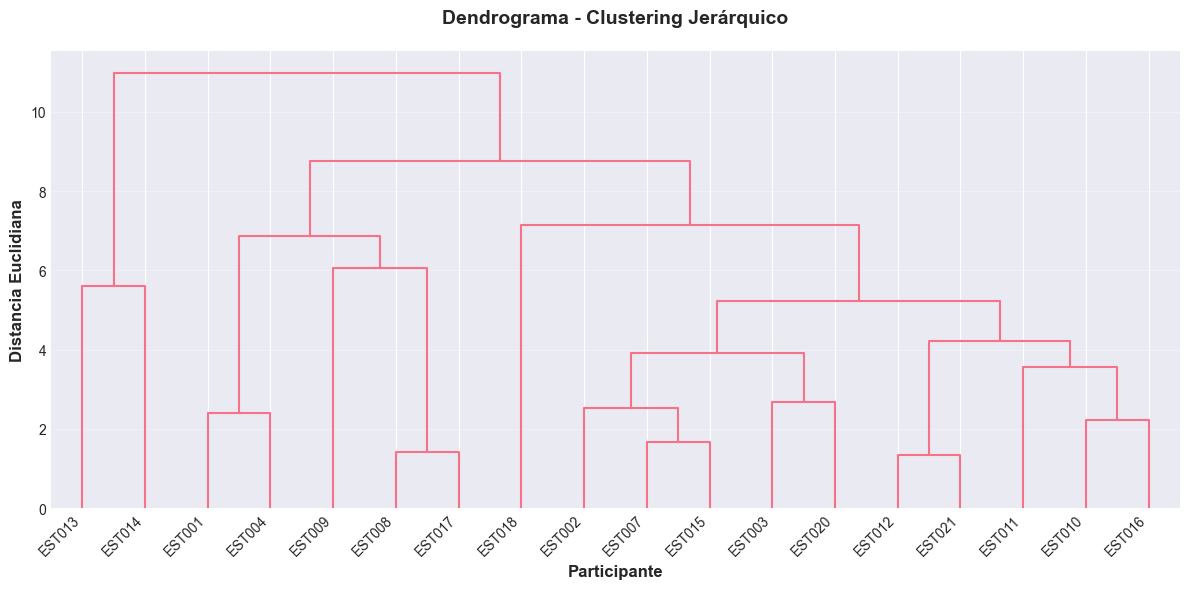

✓ Dendrograma guardado: ../data/results/clustering_dendrograma.png


In [72]:
# Clustering jerárquico para visualizar relaciones
linkage_matrix = linkage(X_scaled, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(
    linkage_matrix,
    labels=df['id_participante'].values,
    leaf_font_size=10,
    color_threshold=0
)

plt.title('Dendrograma - Clustering Jerárquico', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Participante', fontsize=12, fontweight='bold')
plt.ylabel('Distancia Euclidiana', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(output_path / 'clustering_dendrograma.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Dendrograma guardado: {output_path / 'clustering_dendrograma.png'}")

## 8. Visualización: PCA (Reducción a 2D)

Varianza explicada por PC1: 35.3%
Varianza explicada por PC2: 22.3%
Varianza total explicada: 57.6%


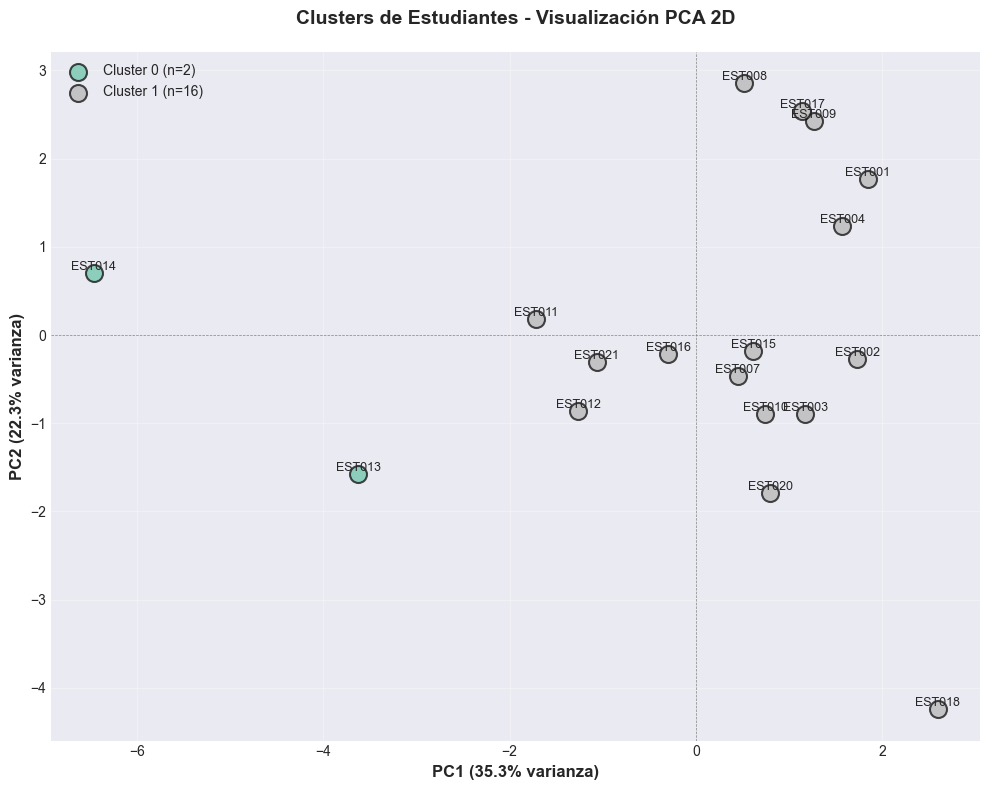


✓ Gráfico PCA guardado: ../data/results/clustering_pca_2d.pdf


In [81]:
# Reducir a 2 componentes principales
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Crear DataFrame
df_pca = pd.DataFrame(
    X_pca,
    columns=['PC1', 'PC2'],
    index=df['id_participante']
)
df_pca['cluster'] = clusters

# Varianza explicada
var_explicada = pca.explained_variance_ratio_
print(f"Varianza explicada por PC1: {var_explicada[0]:.1%}")
print(f"Varianza explicada por PC2: {var_explicada[1]:.1%}")
print(f"Varianza total explicada: {sum(var_explicada):.1%}")

# Visualizar
plt.figure(figsize=(10, 8))

# Scatter plot
colors = plt.cm.Set2(np.linspace(0, 1, k_optimo))
for cluster_id in range(k_optimo):
    mask = df_pca['cluster'] == cluster_id
    plt.scatter(
        df_pca.loc[mask, 'PC1'],
        df_pca.loc[mask, 'PC2'],
        c=[colors[cluster_id]],
        label=f'Cluster {cluster_id} (n={mask.sum()})',
        s=150,
        alpha=0.7,
        edgecolors='black',
        linewidth=1.5
    )
    
    # Etiquetar participantes
    for idx, row in df_pca[mask].iterrows():
        plt.annotate(
            idx,
            (row['PC1'], row['PC2']),
            fontsize=9,
            ha='center',
            va='bottom'
        )

plt.xlabel(f'PC1 ({var_explicada[0]:.1%} varianza)', fontsize=12, fontweight='bold')
plt.ylabel(f'PC2 ({var_explicada[1]:.1%} varianza)', fontsize=12, fontweight='bold')
plt.title(
    'Clusters de Estudiantes - Visualización PCA 2D',
    fontsize=14,
    fontweight='bold',
    pad=20
)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(x=0, color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig(output_path / 'clustering_pca_2d.pdf', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Gráfico PCA guardado: {output_path / 'clustering_pca_2d.pdf'}")

## 9. Radar Charts: Comparación de Perfiles

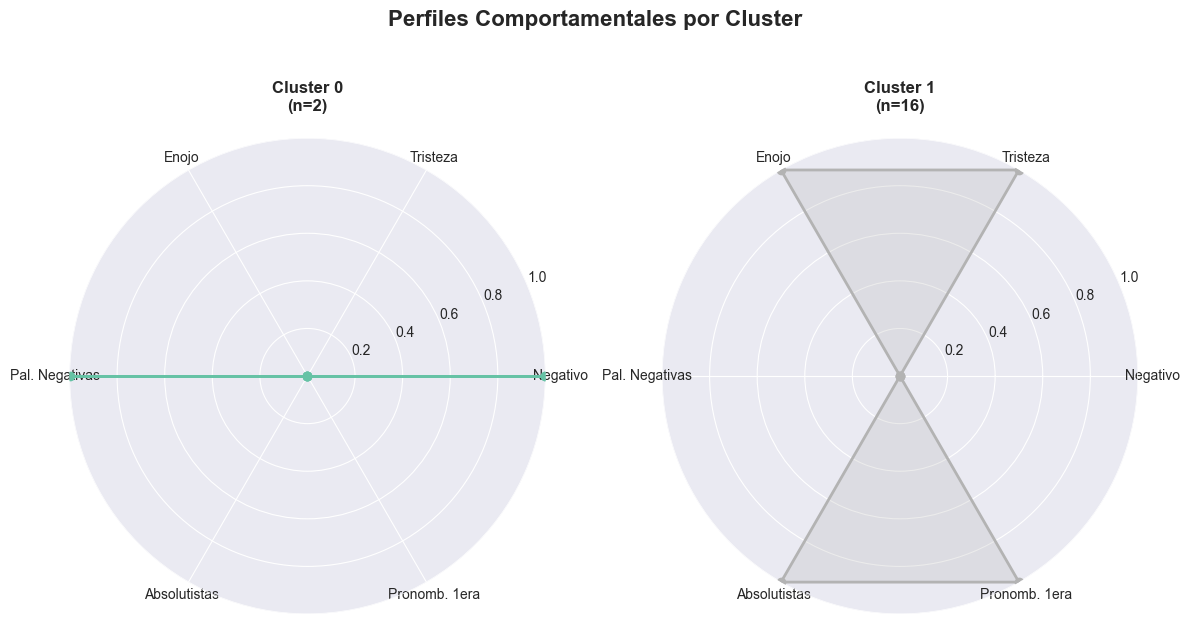

✓ Radar charts guardados: ../data/results/clustering_radar_charts.pdf


In [82]:
# Seleccionar variables clave para radar chart
radar_features = [
    'promedio_score_negativo',
    'promedio_tristeza',
    'promedio_enojo',
    'promedio_negativas',
    'promedio_absolutistas',
    'promedio_pronombres_1era_sing'
]

# Normalizar para radar (0-1)
radar_data = df.groupby('cluster')[radar_features].mean()
radar_data_norm = (radar_data - radar_data.min()) / (radar_data.max() - radar_data.min())

# Crear radar chart
fig, axes = plt.subplots(1, k_optimo, figsize=(6*k_optimo, 6), subplot_kw=dict(projection='polar'))

if k_optimo == 1:
    axes = [axes]

# Ángulos para el radar
angles = np.linspace(0, 2 * np.pi, len(radar_features), endpoint=False).tolist()
angles += angles[:1]  # Cerrar el círculo

# Labels cortos para radar
labels_cortos = [
    'Negativo',
    'Tristeza',
    'Enojo',
    'Pal. Negativas',
    'Absolutistas',
    'Pronomb. 1era'
]

for idx, cluster_id in enumerate(range(k_optimo)):
    ax = axes[idx]
    
    # Datos del cluster
    values = radar_data_norm.loc[cluster_id].tolist()
    values += values[:1]  # Cerrar el círculo
    
    # Plot
    ax.plot(angles, values, 'o-', linewidth=2, color=colors[idx], label=f'Cluster {cluster_id}')
    ax.fill(angles, values, alpha=0.25, color=colors[idx])
    
    # Configuración
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels_cortos, fontsize=10)
    ax.set_ylim(0, 1)
    ax.set_title(
        f'Cluster {cluster_id}\n(n={cluster_counts[cluster_id]})',
        fontsize=12,
        fontweight='bold',
        pad=20
    )
    ax.grid(True)

plt.suptitle(
    'Perfiles Comportamentales por Cluster',
    fontsize=16,
    fontweight='bold',
    y=1.05
)
plt.tight_layout()
plt.savefig(output_path / 'clustering_radar_charts.pdf', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Radar charts guardados: {output_path / 'clustering_radar_charts.pdf'}")

## 10. Comparación Estadística: Clusters vs Salud Mental

In [75]:
# Comparar medidas de salud mental entre clusters
print("\n" + "=" * 80)
print("COMPARACIÓN DE SALUD MENTAL ENTRE CLUSTERS")
print("=" * 80 + "\n")

# Crear tabla comparativa
salud_por_cluster = df.groupby('cluster')[variables_salud].agg(['mean', 'std', 'count'])

for var in variables_salud:
    print(f"\n📊 {var.upper()}")
    print("-" * 80)
    
    for cluster_id in range(k_optimo):
        mean_val = salud_por_cluster.loc[cluster_id, (var, 'mean')]
        std_val = salud_por_cluster.loc[cluster_id, (var, 'std')]
        n_val = int(salud_por_cluster.loc[cluster_id, (var, 'count')])
        
        print(f"  Cluster {cluster_id}: {mean_val:.2f} ± {std_val:.2f} (n={n_val})")
    
    # Test de Kruskal-Wallis (no paramétrico para comparar >2 grupos)
    if k_optimo > 2:
        grupos = [df[df['cluster'] == i][var].dropna().values for i in range(k_optimo)]
        # Filtrar grupos vacíos
        grupos = [g for g in grupos if len(g) > 0]
        
        if len(grupos) >= 2:
            stat, pval = kruskal(*grupos)
            print(f"\n  Kruskal-Wallis H-test: H={stat:.3f}, p={pval:.4f}")
            if pval < 0.05:
                print("  ✓ Diferencia significativa entre clusters (p<0.05)")
            else:
                print("  ✗ No hay diferencia significativa (p≥0.05)")
    elif k_optimo == 2:
        # Mann-Whitney U para 2 grupos
        grupo1 = df[df['cluster'] == 0][var].dropna().values
        grupo2 = df[df['cluster'] == 1][var].dropna().values
        
        if len(grupo1) > 0 and len(grupo2) > 0:
            stat, pval = mannwhitneyu(grupo1, grupo2)
            print(f"\n  Mann-Whitney U-test: U={stat:.3f}, p={pval:.4f}")
            if pval < 0.05:
                print("  ✓ Diferencia significativa entre clusters (p<0.05)")
            else:
                print("  ✗ No hay diferencia significativa (p≥0.05)")

print("\n" + "=" * 80)


COMPARACIÓN DE SALUD MENTAL ENTRE CLUSTERS


📊 DASS_DEPRESION
--------------------------------------------------------------------------------
  Cluster 0: 7.00 ± 4.24 (n=2)
  Cluster 1: 19.12 ± 8.36 (n=16)

  Mann-Whitney U-test: U=2.500, p=0.0672
  ✗ No hay diferencia significativa (p≥0.05)

📊 DASS_ANSIEDAD
--------------------------------------------------------------------------------
  Cluster 0: 4.00 ± 2.83 (n=2)
  Cluster 1: 14.88 ± 8.36 (n=16)

  Mann-Whitney U-test: U=2.500, p=0.0667
  ✗ No hay diferencia significativa (p≥0.05)

📊 DASS_ESTRES
--------------------------------------------------------------------------------
  Cluster 0: 8.00 ± 0.00 (n=2)
  Cluster 1: 24.25 ± 8.67 (n=16)

  Mann-Whitney U-test: U=2.000, p=0.0553
  ✗ No hay diferencia significativa (p≥0.05)

📊 UCLA_TOTAL
--------------------------------------------------------------------------------
  Cluster 0: 45.00 ± 2.83 (n=2)
  Cluster 1: 51.44 ± 5.82 (n=16)

  Mann-Whitney U-test: U=5.000, p=0.1379
  ✗ No 

## 11. Boxplots: Salud Mental por Cluster

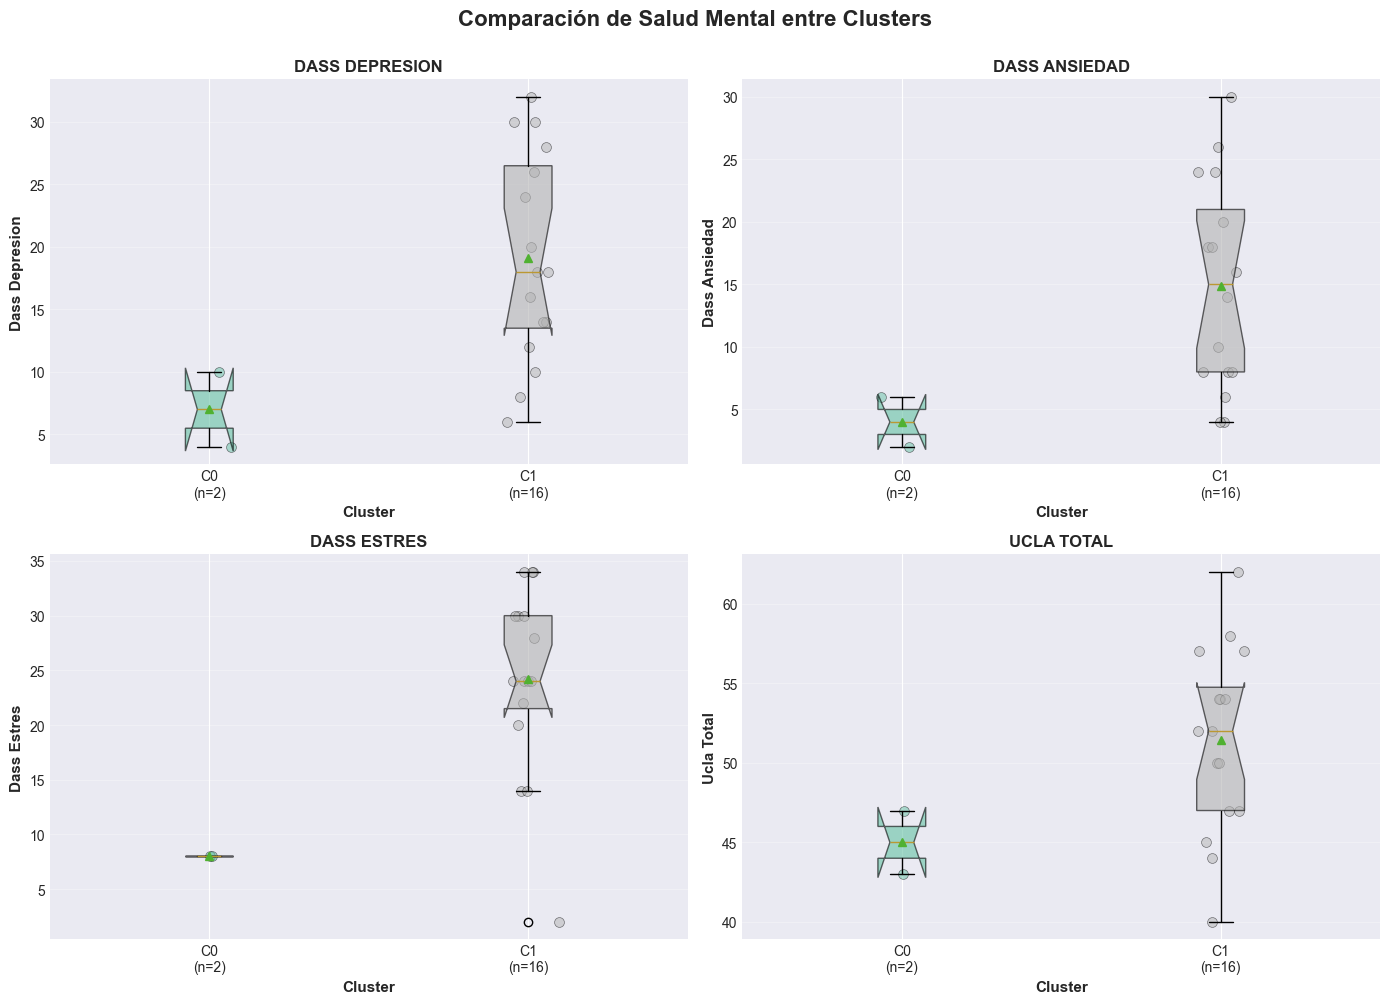

✓ Boxplots guardados: ../data/results/clustering_boxplots_salud.pdf


In [83]:
# Crear boxplots comparativos
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, var in enumerate(variables_salud):
    ax = axes[idx]
    
    # Preparar datos
    data_plot = []
    labels_plot = []
    for cluster_id in range(k_optimo):
        vals = df[df['cluster'] == cluster_id][var].dropna().values
        if len(vals) > 0:
            data_plot.append(vals)
            labels_plot.append(f'C{cluster_id}\n(n={len(vals)})')
    
    # Boxplot
    bp = ax.boxplot(
        data_plot,
        labels=labels_plot,
        patch_artist=True,
        notch=True,
        showmeans=True
    )
    
    # Colorear
    for patch, color in zip(bp['boxes'], colors[:len(data_plot)]):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    # Scatter overlay
    for i, (vals, label) in enumerate(zip(data_plot, labels_plot)):
        x = np.random.normal(i+1, 0.04, size=len(vals))
        ax.scatter(x, vals, alpha=0.5, s=50, color=colors[i], edgecolors='black', linewidth=0.5)
    
    # Configuración
    ax.set_ylabel(var.replace('_', ' ').title(), fontsize=11, fontweight='bold')
    ax.set_xlabel('Cluster', fontsize=11, fontweight='bold')
    ax.set_title(f'{var.replace("_", " ").upper()}', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

plt.suptitle(
    'Comparación de Salud Mental entre Clusters',
    fontsize=16,
    fontweight='bold',
    y=1.00
)
plt.tight_layout()
plt.savefig(output_path / 'clustering_boxplots_salud.pdf', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Boxplots guardados: {output_path / 'clustering_boxplots_salud.pdf'}")

## 12. Reporte Final de Clustering

In [77]:
# Generar reporte textual
reporte_path = output_path / 'clustering_reporte.txt'

with open(reporte_path, 'w', encoding='utf-8') as f:
    f.write("=" * 80 + "\n")
    f.write("REPORTE DE ANÁLISIS DE CLUSTERING\n")
    f.write("Perfiles Comportamentales de Estudiantes\n")
    f.write("=" * 80 + "\n\n")
    
    f.write(f"Fecha de análisis: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Tamaño de muestra: n={len(df)} participantes\n")
    f.write(f"Número de clusters: k={k_optimo}\n")
    f.write(f"Silhouette Score: {silhouette_avg:.3f}\n")
    f.write(f"Variables utilizadas: {len(features_clustering)}\n\n")
    
    f.write("-" * 80 + "\n")
    f.write("PERFILES DE CLUSTERS\n")
    f.write("-" * 80 + "\n\n")
    
    for cluster_id in range(k_optimo):
        f.write(f"\nCLUSTER {cluster_id}\n")
        f.write(f"Tamaño: n={cluster_counts[cluster_id]} ({cluster_counts[cluster_id]/len(df)*100:.1f}%)\n")
        f.write(f"Participantes: {', '.join(df[df['cluster']==cluster_id]['id_participante'].values)}\n\n")
        
        profile = cluster_profiles.loc[cluster_id]
        
        f.write("Características Digitales (Promedios):\n")
        for feat in features_clustering:
            f.write(f"  - {feat}: {profile[feat]:.3f}\n")
        
        salud = df[df['cluster'] == cluster_id][variables_salud].mean()
        f.write("\nSalud Mental (Promedios):\n")
        for var in variables_salud:
            f.write(f"  - {var}: {salud[var]:.2f}\n")
        
        f.write("\n" + "-" * 40 + "\n")
    
    f.write("\n" + "=" * 80 + "\n")
    f.write("INTERPRETACIÓN\n")
    f.write("=" * 80 + "\n\n")
    
    f.write("El análisis de clustering identificó {} grupos naturales de estudiantes\n".format(k_optimo))
    f.write("basados en sus patrones de comportamiento digital. Cada cluster representa\n")
    f.write("un perfil único de expresión emocional, estilo lingüístico y actividad en redes.\n\n")
    
    f.write("RECOMENDACIONES:\n")
    f.write("- Analizar cualitativamente publicaciones representativas de cada cluster\n")
    f.write("- Validar perfiles con entrevistas a participantes de cada grupo\n")
    f.write("- Usar clusters como variable en análisis longitudinales futuros\n")
    f.write("- Considerar intervenciones diferenciadas por perfil comportamental\n\n")
    
    f.write("=" * 80 + "\n")
    f.write("FIN DEL REPORTE\n")
    f.write("=" * 80 + "\n")

print(f"\n✓ Reporte guardado: {reporte_path}\n")

# Mostrar contenido
with open(reporte_path, 'r', encoding='utf-8') as f:
    print(f.read())


✓ Reporte guardado: ../data/results/clustering_reporte.txt

REPORTE DE ANÁLISIS DE CLUSTERING
Perfiles Comportamentales de Estudiantes

Fecha de análisis: 2025-11-16 22:56:38
Tamaño de muestra: n=18 participantes
Número de clusters: k=2
Silhouette Score: 0.351
Variables utilizadas: 13

--------------------------------------------------------------------------------
PERFILES DE CLUSTERS
--------------------------------------------------------------------------------


CLUSTER 0
Tamaño: n=2 (11.1%)
Participantes: EST013, EST014

Características Digitales (Promedios):
  - promedio_score_positivo: 0.031
  - promedio_score_negativo: 0.297
  - promedio_alegria: 0.029
  - promedio_tristeza: 0.007
  - promedio_enojo: 0.004
  - promedio_miedo: 0.002
  - promedio_palabras: 13.250
  - promedio_riqueza_lexica: 0.949
  - promedio_pronombres_1era_sing: 0.000
  - promedio_absolutistas: 0.000
  - promedio_negativas: 5.280
  - num_publicaciones: 2.500
  - total_emojis: 0.000

Salud Mental (Promedios):

## 13. Resumen de Archivos Generados

In [79]:
print("\n" + "=" * 80)
print("RESUMEN FINAL - ANÁLISIS DE CLUSTERING COMPLETADO")
print("=" * 80 + "\n")

print(f" Número óptimo de clusters: k={k_optimo}")
print(f" Silhouette Score: {silhouette_avg:.3f}")
print(f" Participantes analizados: {len(df)}\n")

print(" Archivos generados:")
archivos = [
    'clustering_elbow_silhouette.png',
    'clustering_dendrograma.png',
    'clustering_pca_2d.png',
    'clustering_radar_charts.png',
    'clustering_boxplots_salud.png',
    'clustering_asignaciones.csv',
    'clustering_reporte.txt'
]

for idx, archivo in enumerate(archivos, 1):
    print(f"   {idx}. {output_path / archivo}")

print("\n Para tu tesis:")
print("   - Usa PCA plot para mostrar separación de clusters")
print("   - Usa radar charts para caracterizar perfiles")
print("   - Usa boxplots para comparar salud mental")
print("   - Discute cualitativamente cada perfil identificado\n")

print(" Próximos pasos sugeridos:")
print("   1. Nombrar cada cluster (ej: 'Altamente Emocionales', 'Neutros Activos')")
print("   2. Seleccionar 2-3 publicaciones representativas por cluster")
print("   3. Analizar cualitativamente diferencias entre perfiles")
print("   4. Integrar clusters en discusión de resultados\n")

print("=" * 80)


RESUMEN FINAL - ANÁLISIS DE CLUSTERING COMPLETADO

 Número óptimo de clusters: k=2
 Silhouette Score: 0.351
 Participantes analizados: 18

 Archivos generados:
   1. ../data/results/clustering_elbow_silhouette.png
   2. ../data/results/clustering_dendrograma.png
   3. ../data/results/clustering_pca_2d.png
   4. ../data/results/clustering_radar_charts.png
   5. ../data/results/clustering_boxplots_salud.png
   6. ../data/results/clustering_asignaciones.csv
   7. ../data/results/clustering_reporte.txt

 Para tu tesis:
   - Usa PCA plot para mostrar separación de clusters
   - Usa radar charts para caracterizar perfiles
   - Usa boxplots para comparar salud mental
   - Discute cualitativamente cada perfil identificado

 Próximos pasos sugeridos:
   1. Nombrar cada cluster (ej: 'Altamente Emocionales', 'Neutros Activos')
   2. Seleccionar 2-3 publicaciones representativas por cluster
   3. Analizar cualitativamente diferencias entre perfiles
   4. Integrar clusters en discusión de resultad